# Análisis de inversiones SP500 


In [1]:
import pandas as pd
from datetime import date
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

Se descarga la lista de empresas que componen el sp500, con sus datos

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
simb = list(tickers[0]['Symbol'])


In [3]:
tickers[0].head(3)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888


Se descarga de la appy de yahoo.finance la información del valor de las acciones en el tiempo de las empresas sp500

In [4]:
raw_data = yf.download (tickers = simb, start = "2000-01-01", 
                              end = "2021-12-31", interval = "1d", group_by = 'ticker')
sp500 = raw_data.copy()

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 946695600, endDate = 1640919600


In [5]:
sp500.head(4)

ULTA                                  FRC                 ... WTW  \
           Open High Low Close Adj Close Volume Open High Low Close  ... Low   
Date                                                                 ...       
1999-12-31  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ... NaN   
2000-01-03  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ... NaN   
2000-01-04  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ... NaN   
2000-01-05  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ... NaN   

                                       EMR                                \
           Close Adj Close Volume     Open      High       Low     Close   
Date                                                                       
1999-12-31   NaN       NaN    NaN      NaN       NaN       NaN       NaN   
2000-01-03   NaN       NaN    NaN  28.4375  28.78125  28.15625  28.78125   
2000-01-04   NaN       NaN    NaN  28.7500  28.78125  28.40625  28.43750   
2000-01-05   NaN       NaN    NaN  28.4375  29.12500  28.40625  28.96875   

                                  
            Adj Close     Volume  
Date                              
1999-12-31        NaN        NaN  
2000-01-03  15.237106  2246800.0  
2000-01-04  15.055114  1708200.0  
2000-01-05  15.336361  2190200.0  

[4 rows x 3018 columns]

Se crean dataframes para cada columna, a fines de poder operar con sus valores de forma más sencilla.

In [6]:
Open = pd.DataFrame()
for sim in simb:
    Open = pd.concat([Open, sp500[sim]['Open']], axis=1)
Open.columns = simb

Close = pd.DataFrame()
for sim in simb:
    Close = pd.concat([Close, sp500[sim]['Close']], axis=1)
Close.columns = simb

CloseAdj = pd.DataFrame()
for sim in simb:
    CloseAdj = pd.concat([CloseAdj, sp500[sim]['Adj Close']], axis=1)
CloseAdj.columns = simb


# ------------------ Análisis ------------------

## ¿Que día de la semana invertir? 

### Dataframe __Retorno GAP__

##### __NaN__ vs __.fillna(method='bfill')__

Al utilizar el metodo __bfill__ se replican durante el tiempo en el que la empresa todavía no existía los valores GAP e intradiario, afectando significativamente los calculos. Se optó por proceder sin reemplazar los valores __NaN__

In [23]:
sp500.fillna(method='bfill').head(3)

ULTA                                                  FRC  \
            Open  High        Low  Close  Adj Close     Volume   Open   
Date                                                                    
1999-12-31  33.0  35.0  28.889999  29.82  29.490023  7486900.0  27.25   
2000-01-03  33.0  35.0  28.889999  29.82  29.490023  7486900.0  27.25   
2000-01-04  33.0  35.0  28.889999  29.82  29.490023  7486900.0  27.25   

                                     ...        WTW                        \
                 High    Low  Close  ...        Low      Close  Adj Close   
Date                                 ...                                    
1999-12-31  28.110001  26.99  27.92  ...  42.384106  43.973511  27.844193   
2000-01-03  28.110001  26.99  27.92  ...  42.384106  43.973511  27.844193   
2000-01-04  28.110001  26.99  27.92  ...  42.384106  43.973511  27.844193   

                           EMR                                           \
               Volume     Open      High       Low     Close  Adj Close   
Date                                                                      
1999-12-31  3894441.0  28.4375  28.78125  28.15625  28.78125  15.237106   
2000-01-03  3894441.0  28.4375  28.78125  28.15625  28.78125  15.237106   
2000-01-04  3894441.0  28.7500  28.78125  28.40625  28.43750  15.055114   

                       
               Volume  
Date                   
1999-12-31  2246800.0  
2000-01-03  2246800.0  
2000-01-04  1708200.0  

[3 rows x 3018 columns]

#### Cálculo de todos los retornos gaps

In [8]:
r_gap = np.log(Open/Close.shift(1)).fillna(0)
r_gap.reset_index(inplace=True)
r_gap['day'] = r_gap['index'].map(lambda x: x.weekday()+1)

Como se puede ver, para la empresa __Howmet Aerospace INC__ , los valores al inicio del ciclo de análisis son NaN, observando luego valores GAP de 0.0 como corresponde

In [9]:
sp500.loc[:,'HWM'] #Howmet Aerospace INC

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-12-23,30.389999,31.230000,30.320000,31.129999,31.093887,2557600.0
2021-12-27,31.000000,31.410000,30.770000,31.350000,31.313633,1125900.0
2021-12-28,31.160000,31.709999,31.160000,31.639999,31.603296,1293000.0


In [10]:
print(r_gap.loc[:,'HWM'])

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
5532    0.002966
5533   -0.004185
5534   -0.006079
5535   -0.006977
5536   -0.002532
Name: HWM, Length: 5537, dtype: float64


### Grafico de retorno GAP

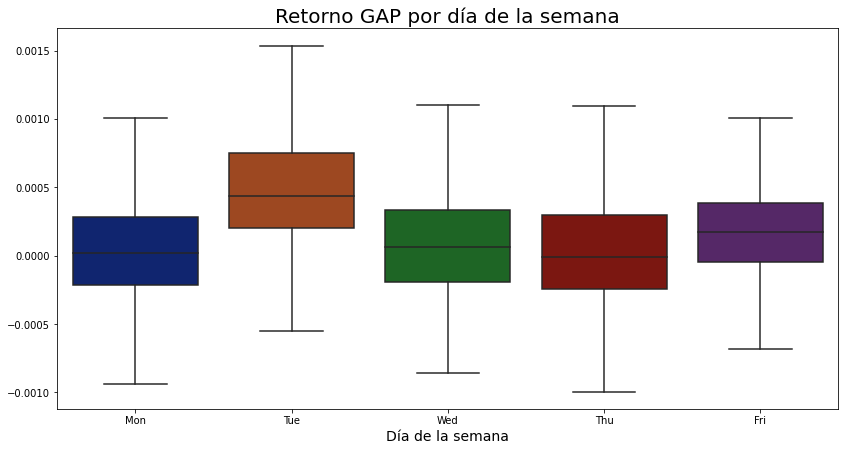

In [24]:
dfbox= r_gap.groupby('day').mean().T
dfbox.rename(columns={1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri'}, inplace=True)

plt.subplots(figsize=(14,7))
sns.boxplot(data=dfbox, showfliers=False, palette='dark')

plt.xlabel('Día de la semana', fontsize=14)
plt.title('Retorno GAP por día de la semana', fontsize=20)
plt.show()

Se puede observar la distribución de los retornos gaps por día, siendo la más favorable la del martes

## Cálculo Retorno Intra

In [12]:
r_intra = np.log(Close/Open).fillna(0)
r_intra.reset_index(inplace=True)
r_intra['day'] = r_intra['index'].map(lambda x: x.weekday()+1)


### Gráfico

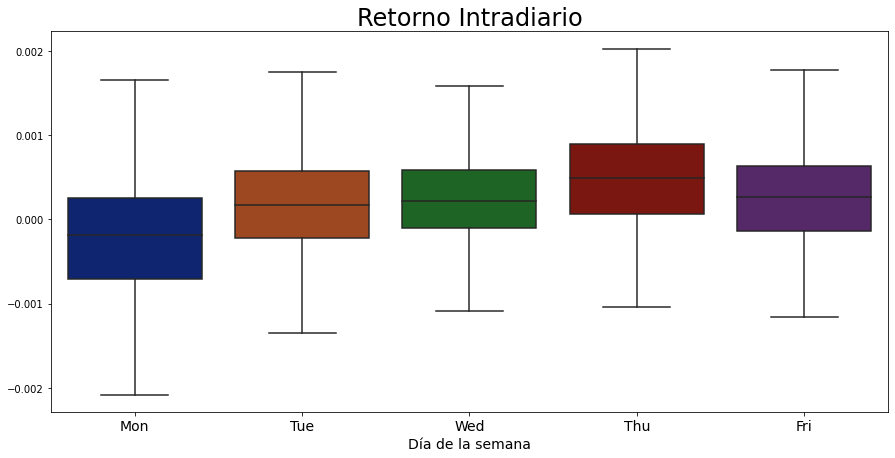

In [13]:
dfbox= r_intra.groupby('day').mean().T
dfbox.rename(columns={1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri'}, inplace=True)
plt.subplots(figsize=(15,7))
sns.boxplot(data=dfbox, showfliers=False, palette='dark')

plt.xlabel('Día de la semana', fontsize=14)
plt.xticks(fontsize=14)
plt.title('Retorno Intradiario', fontsize=24)
plt.show()

Para invertir en el mismo día, se observan mayores valores los días jueves

## ¿En qué empresa invertir? 

In [14]:
df_merge = tickers[0][['Symbol','GICS Sector', 'Security']]
df_merge.rename(columns={'Symbol':'Ticker'}, inplace=True)
df_merge.head(3)

,Ticker,GICS Sector,Security
0,MMM,Industrials,3M
1,AOS,Industrials,A. O. Smith
2,ABT,Health Care,Abbott


Se calcula de forma simplificada el crecimiento de cada empresa desde el día que abrió al cierre al final del ciclo de análisis con la siguiente fórmula

$ Crecimiento = \frac{Ultimo\space cierre - 1er\space Apertura}{1er\space Apertura} $

In [15]:
crecimiento = (Close.fillna(method='bfill').iloc[-1] -Open.fillna(method='bfill').iloc[0])/Open.fillna(method='bfill').iloc[0]

df = crecimiento.reset_index()
df.rename(columns={'index': 'Ticker', 0:'Crecimiento porcentual'}, inplace=True)

df = df.merge(df_merge,how='left', on='Ticker')
df.rename(columns={'Security': 'Empresa','GICS Sector':'Tipo de Industria' }, inplace=True)

df.head(4)

,Ticker,Crecimiento porcentual,Tipo de Industria,Empresa
0,MMM,2.698425,Industrials,3M
1,AOS,22.460858,Industrials,A. O. Smith
2,ABT,7.910653,Health Care,Abbott
3,ABBV,2.892612,Health Care,AbbVie


In [16]:
print(df.groupby('Empresa').sum().sort_values(by=['Crecimiento porcentual'], ascending=False)[:9])

                    Crecimiento porcentual
Empresa                                   
Monster Beverage               1068.478523
Netflix                         528.293194
Old Dominion                    376.501014
Nvidia                          299.556176
Tesla, Inc.                     280.668416
Tractor Supply                  234.798968
Apple Inc.                      189.306533
Intuitive Surgical              179.397219
Idexx Laboratories              164.007701


## ¿En qué industria debería hacerlo?

In [17]:
df.groupby('Tipo de Industria').sum().sort_values(by=['Crecimiento porcentual'], ascending=False)[:9]

,Crecimiento porcentual
Tipo de Industria,
Consumer Discretionary,1698.587151
Health Care,1681.105659
Information Technology,1677.999069
Consumer Staples,1226.386334
Industrials,1181.564408
Communication Services,779.332053
Financials,509.895210
Materials,238.175628
Real Estate,200.043113


## Mayor volatilidad VIX

Se calcula la volatilidad

In [18]:
variaciones = CloseAdj.pct_change()
variaciones.tail(3)

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
2021-12-28 00:00:00,0.005320,0.009917,-0.006998,-0.000149,-0.001090,-0.000144,0.018640,0.013016,-0.014402,-0.000893,...,-0.001422,0.009145,-0.012788,0.011973,0.010398,-0.000217,-0.014860,0.003130,0.001587,-0.009168
2021-12-29 00:00:00,0.004335,0.003156,0.005125,0.007218,0.012310,0.000361,0.007350,0.001195,-0.000123,0.007884,...,-0.001215,0.008678,-0.017118,0.005028,-0.001339,0.004928,0.006362,0.000156,0.005387,0.011382
2021-12-30 00:00:00,-0.004316,-0.006060,-0.001346,0.004211,0.000608,-0.003828,0.004914,-0.002238,0.002178,-0.009879,...,-0.002146,-0.016616,0.013768,0.003973,-0.002178,-0.001947,-0.005956,0.000312,-0.005043,-0.007570


In [19]:
volatilidad = variaciones.rolling(250).std()*100*(250)**0.5
volatilidad.fillna(0, inplace=True)
volatilidad.tail(3)

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
2021-12-28 00:00:00,18.573694,27.886513,21.204112,20.179311,33.356617,19.762460,31.207557,20.828143,29.331691,19.223389,...,25.313436,22.580502,42.013254,19.157816,21.773945,18.215004,27.999559,24.462176,35.084929,19.829051
2021-12-29 00:00:00,18.574586,27.886749,21.190674,20.119326,33.377102,19.725068,31.183069,20.809985,29.328084,19.194906,...,25.223887,22.591619,42.043047,19.102655,21.755343,18.192813,28.003039,24.428374,35.085216,19.844302
2021-12-30 00:00:00,18.502039,27.837207,21.187067,20.045109,33.292155,19.629699,31.035966,20.778017,29.170769,18.747872,...,24.996424,22.356607,41.745087,19.043400,21.651111,18.002195,27.955534,24.422411,35.065536,19.821651


In [20]:
print(volatilidad.T.mean())

1999-12-31     0.000000
2000-01-03     0.000000
2000-01-04     0.000000
2000-01-05     0.000000
2000-01-06     0.000000
                ...    
2021-12-23    27.651974
2021-12-27    27.673565
2021-12-28    27.665172
2021-12-29    27.644843
2021-12-30    27.539839
Length: 5537, dtype: float64


### Gráfico de la volatilidad VIX SP500

In [21]:
Vix = volatilidad.T.mean()
fig = px.line(x=Vix.index ,y=Vix , title='VIX')

fig.show()

Se pueden apreciar en el gráfico 2 picos muy pronunciados, el 1ero sucedido debido a la crisis financiera del 2008, teniendo su pico en _junio 2009_ y la segunda debido a la pandemia por coronavirus,  teniendo su pico en _febrero 2021_

In [22]:
volatilidad.T.mean().idxmax()

Timestamp('2009-06-02 00:00:00')